# <center> **Compte-rendu projet Optimisation**
<div align = right> Camille Dubois & Florian Garbe

In [1]:
# on importe les modules nécessaires
import numpy as np
from casadi import *
import time
import matplotlib.pyplot as plt

On pose la fonction suivante à minimiser :
$$
\begin{align*}
 f: p= \left(\begin{matrix} p_1 \\ \vdots\\ p_N \end{matrix}\right) \longrightarrow \sum_{i=0}^{N-1} \|p_{i+1}-R_i\Delta p_{i,i+1} -p_i \|_2^2 + \gamma \sum_{i, j \in L}\|p_j - R_i\Delta p_{i,j}-p_i\|_2^2
 \\
 c_1(p) = p_{,3} - \pi = \theta_i - \pi \leq 0 \\
 c_2(p) =- (p_{,3} + \pi) = -(\theta_i + \pi) < 0
 \end{align*}
$$



Ainsi les variables de décisions sont $p = \left(\begin{matrix} p_1 \\ \vdots \\ p_N\end{matrix}\right) \in \mathbb{R}^{N,3} $ au nombre de $3N$.

---

### Question 2.

**f convexe ?** : Remarquons que tous les déplacements étant non nuls, on a pour tout $i$, $(\delta x_i) ^2 + (\delta y_i) ^2 \neq 0$. Posons, juste pour cette question : $x=0; ~y=0; ~\theta_i = 0 \quad \forall i>0$, et $p$ la matrice $\begin{pmatrix} x & y & \theta \end{pmatrix}$ associée.

On a $f$ convexe $\implies \quad h : \theta_0 \longmapsto f(p)$ convexe (ici $p$ est entièrement définie par $\theta_0$). Cette application découle de la définition de la convexité.


h est de classe $\mathcal{C}^\infty$, donc on peut en particulier calculer $h''(\theta_0) = -2 \left( (cos(\theta_0) + sin(\theta_0)) \delta x_0 + (\cos(\theta_0) - sin(\theta_0))\delta y_0 \right)$

D'où : $$ \left\{ \begin{array}{cc} h''(\pi) = +2 (\delta x_0 + \delta y_0) \\ h''(\pi/2) = -2(\delta x_0 - \delta y_0) \\ h''(\theta_0 \pm \pi) = - h''(\theta_0) \end{array} \right.$$

Ainsi, étant donné que  l'on a $\delta x_0 \neq 0$ ou $\delta y_0 \neq 0$, nécessairement $h''$ est strictement négative en un point ($\in \{\pi, \pi/2, 0, -\pi/2 \}$). Donc $h$ n'est pas convexe et par contraposée $\boxed{f \text{ n'est pas convexe}}$.

**c convexe ?** : Rappelons que $c = \left( \begin{array}{l} c_1 \\ c_2 \end{array} \right)$. Les fonctions $c_1$ et $c_2$ sont affines donc convexes : $\boxed{ c \text{ est convexe}}$. De plus, l'ensemble $L = \{p \in \R, c1(p) \leq 0 \text{ et } c_2(p) \leq 0 \}$ est un fermé (il s'agit de $\R^2 \times [-\pi, \pi]$).

**existence et unicité de la solution ?** : Rappelons que $f$ est continue sur $L$. Remarquons que $f(p) \xrightarrow[|x|+|y|\to+\infty]{} +\infty$. De plus si l'on se place uniquement sur $L$, alors cette relation s'écrit : $f(p) \xrightarrow[\|p\|\to+\infty]{} +\infty$. Il en découle donc que le problème d'optimisation a une solution, sans que l'on puisse dire si cette dernière est unique.


---

### Question 3.
&ensp;&ensp;&ensp; On réalise la fonction permettant de lire les données du fichier INTEL.txt qui contient 1227 lignes ODO, donc 3 681 incconues sont liées à ce jeu de données.

In [2]:
# on importe les modules nécessaires
import numpy as np
from casadi import *
import time
import matplotlib.pyplot as plt

In [3]:
def lec_don(f:str):
    """ Cette fonction retourne les deltap_i,i+1 associé au mesures d'odométrie
        ainsi que les deltap_i,j associé au mesures de fermetures
        
        return a tuple of array. 
            - The first array is the deltap_i,i+1 linked to the odométrie sorted
            in rising order.
            
            - The second one is linked to the closing sorted as well in rising
            order.
            
        parameters :
            - The file that contains the data"""

    ODO = np.zeros((1227, 3)) # l'array d'odométrie
    LOOP = np.zeros((256, 5)) # L'array de fermeture
    num_line = 0 # Le numéro de la ligne en cours
    
    with open(f) as file:
        for line in file:
            type, p1, p2, dx, dy, dtheta = line.split(' ')
            if type == "EDGE_ODO":
                ODO[num_line] = [float(dx), float(dy), float(dtheta)]
            if type == "EDGE_LOOP":
                #print(num_line -1227, type)
                LOOP[num_line - 1227] = [int(p1), int(p2), float(dx), float(dy), float(dtheta)]
            
            num_line +=1

    return (ODO, LOOP)



In [4]:
ODO, LOOP = lec_don("INTEL.txt")
# Attention ODO est constitué sur la i-ème ligne des informations de 
# Deltap_i,i+1, tandis que LOOP contient sur chaque les lignes les
# les informations i, j pour identifier le Deltap_i,j et les infos associées

---

&ensp; $\longrightarrow$ Dans un premier temps, nous avons voulu ajouter les contraintes sur thêta dans le problème d'optimisation. Cependant, il semble plus judicieux, en plus de la contrainte (que l'on laisse par sécurité) de s'assurer artificiellement que thêta reste bien entre -pi et pi.  
Pour réaliser cela, nous voudrions utiliser la fonction remainder de numpy. Cependant cette fonction n'est pas compatible avec du code <code>casadi</code>. Nous programmons donc à côté une fonction qui permet de réaliser ceci : échec ! Cela ne fonctionne pas. En effet les matrices sous casadi présente un type particulier : pour les plus générales, le type est <code>MX</code>. Chaque matrice est associé à une représentation symbolique et non à des valeurs numériques. L'ordinateur enregistre les opérations que l'on applique et non pas les valeurs prises par les coefficients de la matrice. Ceci empêche la fonction <code>remainder</code> de fonctionner parce qu'elle implique un test booléen qui ne peut être réalisé sur une matrice qui ne contient pas de valeures numériques.  
&ensp; Pour ne pas perdre tout le travail effectué avec le module casadi, nous optimisons notre fonction sans les contraintes selon $\theta$, ce qui n'est pas absurde parce que pour minimiser notre fonction, les $\theta$ vont "naturellement" s'accorder sur un intervalle de longueur $2\pi$.  

&ensp; Nous réalisons cependant cette question avec une méthode de descente de gradient (à pas fixe et avec les conditions de wolfe) aussi pour avoir plus de flexibilité et avancer dans notre projet.

## Avec Casadi
### Question 4
&ensp; Il est nécessaire de définir dans un premier temps la fonction f à minimiser : on utilise pour cela le module <code> casadi </code> qui ne nécessite pas de calculer le gradient de la fonction. 

In [5]:
def remainder(a, b):
    r = 0
    k = 0 
    while k*b < a:
        k += 1 
        r = a - (k-1)*b
    return r

In [6]:
def remainder(a, b):
    r = 0
    k = 0 
    while k*b < a:
        k += 1 
        r = a - (k-1)*b
    return r

In [7]:
print(remainder(3.5, 1.5), np.remainder(3.5,1.5))

0.5 0.5


In [8]:
print(remainder(3.5, 1.5), np.remainder(3.5,1.5))

0.5 0.5


In [9]:
opti = casadi.Opti();
p = opti.variable(1227, 3) # on a 1227 poses qui contienent 3 inconnues chacune

# on constitue ensuite notre fonction f à minimiser
x1, y1, theta1 = p[0,0], p[0,1], p[0,2]
x, y , theta = 0, 0, 0
dx, dy , dtheta = ODO[0]
f = (x1 - np.cos(theta)*dx + np.sin(theta)*dy - x)**2 + (y1 - np.sin(theta)*dx - np.cos(theta)*dy - y)**2 + (theta1 - dtheta - theta)**2
# on commence par les relations d'odométrie
for i in range(1226):
    x, y , theta = p[i,0], p[i,1], p[i,2]
    x1, y1, theta1 = p[i+1,0], p[i+1,1], p[i+1,2]
    dx, dy , dtheta = ODO[i+1]

    f += (x1 - np.cos(theta)*dx - np.sin(theta)*dy - x)**2 + (y1 - np.sin(theta)*dx - np.cos(theta)*dy - y)**2 + (theta1 - dtheta - theta)**2

opti.minimize(f)
# # les contraintes 
# for i in range(1227) :
#     opti.subject_to(p[i, 2]-np.pi <= 0)
#     opti.subject_to(-(p[i, 2]+np.pi) <= 0)

# La solution à notre problème d'optimisation
opti.solver('ipopt');
sol = opti.solve();
res = sol.value(p)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    12215

Total number of variables............................:     3681
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

In [10]:
print(res, res.shape)

[[ 9.42672242e-19  5.93624906e-20 -6.42051671e-04]
 [ 1.88534448e-18  1.18724981e-19 -1.18010334e-03]
 [ 1.10041276e-02 -9.74984004e-04 -3.56215501e-03]
 ...
 [-7.25814182e+00 -3.07510771e+01  8.35505136e+01]
 [-7.28954792e+00 -3.06492448e+01  8.35337826e+01]
 [-7.28954792e+00 -3.06492448e+01  8.35331206e+01]] (1227, 3)


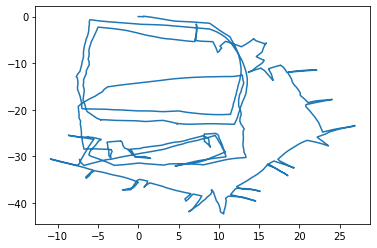

In [11]:
# on affiche ici le graphe des poses
plt.plot(res[:, 0], res[:, 1])
plt.show()

---

### Question 5
&ensp; On ajoute les relations de fermeture de boucle

In [12]:
opti = casadi.Opti();
p = opti.variable(1227, 3) # on a 1227 poses qui contienent 3 inconnues chacune

# on constitue ensuite notre fonction f à minimiser
x1, y1, theta1 = p[0,0], p[0,1], p[0,2]
x, y , theta = 0, 0, 0
dx, dy , dtheta = ODO[0]
f = (x1 - np.cos(theta)*dx - np.sin(theta)*dy - x)**2 + (y1 - np.sin(theta)*dx - np.cos(theta)*dy - y)**2 + (theta1 - dtheta - theta)**2
# on commence par les relations d'odométrie
for i in range(1226):
    x, y , theta = p[i,0], p[i,1], p[i,2]
    x1, y1, theta1 = p[i+1,0], p[i+1,1], p[i+1,2]
    dx, dy , dtheta = ODO[i+1]

    f += (x1 - np.cos(theta)*dx - np.sin(theta)*dy - x)**2 + (y1 - np.sin(theta)*dx - np.cos(theta)*dy - y)**2 + (theta1 - dtheta - theta)**2

# Puis on ajoute les relations de fermetures (pour la question 5)
for k in range (256):
    i, j, dx, dy, dtheta = LOOP[k]
    xi, yi, thetai = p[i,0], p[i,1], p[i,2]
    xj, yj, thetaj = p[j,0], p[j,1], p[j,2]

    f += (xj - np.cos(thetai)*dx - np.sin(thetai)*dy - xi)**2 + (yj - np.sin(thetai)*dx - np.cos(thetai)*dy - yi)**2 + (thetaj - dtheta - thetai)**2

opti.minimize(f)
# les contraintes 
opti.subject_to(p[2] - np.pi <=0)
opti.subject_to( -(p[2] + np.pi) <0 )

# La solution à notre problème d'optimisation
opti.solver('ipopt');
sol = opti.solve();
res = sol.value(p)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:    13495

Total number of variables............................:     3681
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

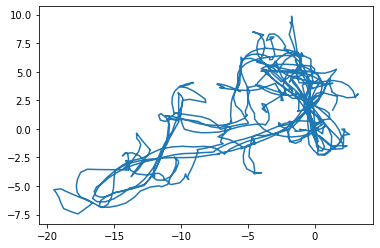

In [13]:
# on affiche ici le graphe des poses
plt.plot(res[:, 0], res[:, 1])
plt.show()

---

## Avec descente de gradient
### Question 4

In [14]:
N = 1227

#On fixe un départ calculé uniquement avec les mesures de récurrence d'odométrie
p0 = np.zeros(3*N)

for i in range(1, N) : 
    dx, dy, dtheta = ODO[i]
    p0[i] = p0[i-1] + np.cos(p0[i-1+2*N])*dx - np.sin(p0[i-1+2*N])*dy
    p0[i+N] = p0[i-1+N] + np.sin(p0[i-1+2*N])*dx + np.sin(p0[i-1+2*N])*dy
    p0[i+2*N] = p0[i-1+2*N] + dtheta

Pour des comodités de notations, on pose $q \in \R^{3N}$, avec : $q_1, ..., q_N = x_1, ..., x_N ; \quad q_{N+1}, ..., q_{2N} = y_1, ..., y_N ; \quad q_{2N+1}, ..., q_{3N} = \theta_1, ..., \theta_N$. On définit la fonction $h$ naturellement de sorte que $h(q) = f(p)$.

Notons de plus $h_{ij}(q) = \| p_j - R_i \Delta p_{ij} - p_i \|_2^2$.

On peut calculer le gradient de $h_{ij}$ :
$$
h_{ij}(q) = (x_j - x_i -\cos \theta_i~\delta x_{ij} + \sin \theta_i~\delta y_{ij})^2 + (y_j - y_i -\sin \theta_i~\delta x_{ij} - \cos \theta_i~\delta y_{ij})^2 + (\theta_j - \theta_i - \delta \theta_{ij})^2 \\
\begin{align*}
\nabla h_{ij}(q) . e_i &= -2(x_j - x_i -\cos \theta_i~\delta x_{ij} + \sin \theta_i~\delta y_{ij}) \\
\nabla h_{ij}(q) . e_j &= +2(x_j - x_i -\cos \theta_i~\delta x_{ij} + \sin \theta_i~\delta y_{ij}) \\
\nabla h_{ij}(q) . e_{i+N} &= -2(y_j - y_i -\sin \theta_i~\delta x_{ij} - \cos \theta_i~\delta y_{ij}) \\
\nabla h_{ij}(q) . e_{j+N} &= +2(y_j - y_i -\sin \theta_i~\delta x_{ij} - \cos \theta_i~\delta y_{ij}) \\
\nabla h_{ij}(q) . e_{i+2N} &= 2 \left( (\sin \theta_i~\delta x_{ij} + \cos \theta_i~\delta y_{ij}) (x_j - x_i -\cos \theta_i~\delta x_{ij} + \sin \theta_i~\delta y_{ij}) + (-\cos \theta_i~\delta x_{ij} + \sin \theta_i~\delta y_{ij})(y_j - y_i -\sin \theta_i~\delta x_{ij} - \cos \theta_i~\delta y_{ij}) - (\theta_j - \theta_i - \delta \theta_{ij})\right) \\
\nabla h_{ij}(q) . e_{j+2N} &= 2(\theta_j - \theta_i - \delta \theta_{ij}) \\
\nabla h_{ij}(q) . e_k &= 0 \text{ sinon}
\end{align*}
$$

On en déduit donc le gradient de $h$ en sommant les relations précédentes.

In [15]:
# Définition des fonctions que l'on va utiliser. On intègre deux paramètres,
# bouclage et lbd pour faciliter l'utilisation dans les questions 5 et 6.

def h(q, bouclage = False, lbd = 1) :
    res = 0
    for i in range(N-1):
        xi, yi, thetai = q[i], q[i+N], q[i+2*N]
        xj, yj, thetaj = q[i+1], q[i+1+N], q[i+1+2*N]
        dx, dy, dtheta = ODO[i]

        res += (xj - xi - np.cos(thetai) * dx + np.sin(thetai) * dy)**2 + (yj - yi - np.sin(thetai) * dx - np.cos(thetai) * dy)**2 + (thetaj - thetai - dtheta)**2

    if bouclage : 
        for boucle in LOOP : 
            i, j, dx, dy, dtheta = boucle
            i = int(i)
            j = int(j)
            xi, yi, thetai = q[i-1], q[i-1+N], q[i-1+2*N]
            xj, yj, thetaj = q[j-1], q[j-1+N], q[j-1+2*N]

            res += lbd * ((xj - xi - np.cos(thetai) * dx + np.sin(thetai) * dy)**2 + (yj - yi - np.sin(thetai) * dx - np.cos(thetai) * dy)**2 + (thetaj - thetai - dtheta)**2)

    return res

def grad_h_ij(i, j, xi, xj, yi, yj, thetai, thetaj, dx, dy, dtheta):

    res = np.zeros(3*N)
    res[i-1] = -2 * (xj - xi - np.cos(thetai) * dx + np.sin(thetai) * dy)
    res[j-1] = 2 * (xj - xi - np.cos(thetai) * dx + np.sin(thetai) * dy)
    res[i-1 + N] = -2 * (yj - yi - np.sin(thetai) * dx - np.cos(thetai) * dy)
    res[j-1+N] = 2 * (yj - yi - np.sin(thetai) * dx - np.cos(thetai) * dy)
    res[i-1+2*N] = 2* ((np.sin(thetai)*dx+ np.cos(thetai)*dy) * (xj - xi - np.cos(thetai) * dx + np.sin(thetai) * dy) + (- np.cos(thetai)*dx + np.sin(thetai)*dy) * (yj - yi - np.sin(thetai) * dx - np.cos(thetai) * dy) - (thetaj - thetai - dtheta))
    res[j-1+2*N] = 2 * (thetaj - thetai - dtheta)

    return res


def grad_h(q, bouclage = False, lbd = 1) :
    res = np.zeros(3*N)

    for i in range(N-1):
        xi, yi, thetai = q[i], q[i+N], q[i+2*N]
        xj, yj, thetaj = q[i+1], q[i+1+N], q[i+1+2*N]
        dx, dy, dtheta = ODO[i]

        res += grad_h_ij(i+1, i+2, xi, xj, yi, yj, thetai, thetaj, dx, dy, dtheta)
    
    if bouclage :
        for boucle in LOOP :
            i, j, dx, dy, dtheta = boucle
            i = int(i)
            j = int(j)
            xi, yi, thetai = q[i-1], q[i-1+N], q[i-1+2*N]
            xj, yj, thetaj = q[j-1], q[j-1+N], q[j-1+2*N]

            res += lbd * grad_h_ij(i, j, xi, xj, yi, yj, thetai, thetaj, dx, dy, dtheta)
    
    return res

On code la méthode de la descente de gradient à pas fixe. La recherche d'un pas qui permet la convergence est faite par tatonnement.

In [16]:
def optim_gradient_fixed_step(grad_fun, x0, l, bouclage = False, lbd = 1., max_iter = 2000, epsilon_grad_fun = 0.2):
    xk = x0
    iter = 0
    while (iter < max_iter and np.linalg.norm(grad_fun(xk, bouclage, lbd)) > epsilon_grad_fun) :
        xk = xk - l * grad_fun(xk, bouclage, lbd)
        iter += 1
    print("Nombre d'itérations : ", iter)
    print  ("||grad(h)||:" , np.linalg.norm(grad_fun(xk, bouclage, lbd)))
    return xk

In [17]:
start = time.time()
res4_pf = optim_gradient_fixed_step(grad_h, p0, 0.1) #pf = pas fixe
end = time.time()
t4_pf = end-start
print("Temps d'exécution : ", t4_pf, "s")

Nombre d'itérations :  167
||grad(h)||: 0.19882842094570685
Temps d'exécution :  11.576908588409424 s


Et la méthode de recherche avec les conditions de Wolfe (on n'est pas certains de trouver une solution à la recherche des pas $l_i$).

In [18]:
def wolfe_step(fun, grad_fun, bouclage, lbd, xk, pk, c1 = 0.25, c2 = 0.75, M = 1000):
    l_moins = 0
    l_plus = 0
    f_xk = fun(xk, bouclage, lbd)
    grad_f_xk = grad_fun(xk, bouclage, lbd)
    li = 0.1
    i = 0
    while(i < M):
        if (fun(xk+li*pk, bouclage, lbd)>(f_xk+c1*li*np.dot(grad_f_xk,pk))):
            l_plus = li
            li = (l_moins+l_plus)/2.0
        elif (np.dot(grad_fun(xk +li*pk, bouclage, lbd), pk) < c2*np.dot(grad_fun(xk, bouclage, lbd), pk)):
            l_moins = li
            if (l_plus == 0) :
                li = 2*li
            else :
                li = (l_moins+l_plus)/2.0
        else : break
        i = i + 1
    return li


def optim_gradient_wolfe_step(fun, grad_fun, x0, bouclage = False, lbd = 1., max_iter = 1000, epsilon_grad_fun = 0.2):
    xk = x0
    iter = 0
    while (iter < max_iter and np.linalg.norm(grad_fun(xk, bouclage, lbd)) > epsilon_grad_fun) :
        pk = - grad_fun(xk, bouclage, lbd)
        l = wolfe_step(fun, grad_fun, bouclage, lbd, xk, pk)
        xk = xk - l * grad_fun(xk, bouclage, lbd)
        iter += 1
    print("Nombre d'itérations : ", iter)
    print  ("||grad(h)||:" , np.linalg.norm(grad_fun(xk, bouclage, lbd)))
    return xk

In [19]:
start = time.time()
res4_wo = optim_gradient_wolfe_step(h, grad_h, p0) #wo = Wolfe
end = time.time()
t4_wo = end-start
print("Temps d'exécution : ", t4_wo, "s")

Nombre d'itérations :  49
||grad(h)||: 0.19934141142471445
Temps d'exécution :  15.737576484680176 s


Comparaison des résultats des deux méthodes (Wolfe et pas fixe) :

- La méthode avec pas de Wolfe requiert moins d'itérations pour converger,
- Si le pas $l_i$ que l'on choisit par défaut à chaque itération (avant de le corriger dans la recherche du pas de Wolfe) est trop éloigné du pas final, on perd beaucoup de performance en terme de temps d'exécution (env. $30s$ pour un pas $l_i^0 = 1$ contre env. $21s$ pour un pas $l_i^0 = 0.1$ plus rapide à corriger),
- La méthode à pas fixe semble converger un peu plus rapidement en terme de temps d'exécution (pour une valeur de norme du gradient inférieure à $0.2$),
- Les résultats trouvés sont quasi-similaires, en terme de norme et de points (cf. plot ci-dessous). La trajectoire est assez proche de celle calculée comme point de départ, ce qui est plutôt cohérent puisque l'on ne considère ici que les relations d'odométrie.

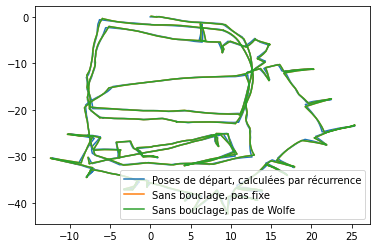

In [20]:
plt.plot(p0[:N], p0[N:2*N], label = "Poses de départ, calculées par récurrence")
plt.plot(res4_pf[:N], res4_pf[N:2*N], label = "Sans bouclage, pas fixe")
plt.plot(res4_wo[:N], res4_wo[N:2*N], label = "Sans bouclage, pas de Wolfe")
plt.legend()
plt.show()

---

### Question 5

In [21]:
start = time.time()
res5_pf = optim_gradient_fixed_step(grad_h, res4_pf, 0.01, bouclage = True, max_iter=1000) #pf = pas fixe
end = time.time()
t5_pf = end-start
print("Temps d'exécution : ", t5_pf, "s")

Nombre d'itérations :  1000
||grad(h)||: 31.09177941864244
Temps d'exécution :  90.38020753860474 s


In [22]:
start = time.time()
res5_wo = optim_gradient_wolfe_step(h, grad_h, res4_pf, bouclage = True) #wo = Wolfe
end = time.time()
t5_wo = end-start
print("Temps d'exécution : ", t5_wo, "s")

Nombre d'itérations :  1000
||grad(h)||: 18.589713203919356
Temps d'exécution :  345.6378290653229 s


Comparaison des résultats des deux méthodes (Wolfe et pas fixe) :

- Aucune des deux méthodes ne converge en moins de 1000 itérations,
- Les temps d'exécution sont bien plus longs,
- Les deux méthodes n'aboutissent pas à la même approximation pour les limites d'itération appliquées,
- Le résultat trouvé semble plus cohérent avec la carte fournie dans le sujet.

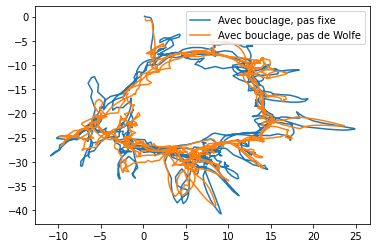

In [23]:
plt.plot(res5_pf[:N], res5_pf[N:2*N], label = "Avec bouclage, pas fixe")
plt.plot(res5_wo[:N], res5_wo[N:2*N], label = "Avec bouclage, pas de Wolfe")
plt.legend()
plt.show()

### Question 6

In [33]:
res6 = np.zeros((5, res4_pf.shape[0]))
t6 = np.zeros(5)

res6[0] = res4_pf
res6[2] = res5_pf

t6[0] = t4_pf
t6[2] = t5_pf

for i in range(1, 5) :
    start = time.time()
    res6[i] = optim_gradient_fixed_step(grad_h, res4_pf, 0.015, bouclage = True, lbd = i/4, max_iter=1000) #pf = pas fixe
    end = time.time()
    t6[i] = end-start

for i in range(1, 5) :
    print("pour gamma = ", i/4, "on a ||grad(h)||=", grad_h(res6[i], bouclage=True, lbd=i/4), " et un temps d'exécution de ", t6[i])

Nombre d'itérations :  1000
||grad(h)||: 18.444426116712584
Nombre d'itérations :  1000
||grad(h)||: 18.495224292296783
Nombre d'itérations :  1000
||grad(h)||: 17.744395266469976
Nombre d'itérations :  1000
||grad(h)||: 107.6399837069079
pour lambda =  0.25 on a ||grad(h)||= [-0.01283758 -0.01313895 -0.01371407 ...  0.90406655  0.9044436
  0.92182369]  et un temps d'exécution de  88.05772471427917
pour lambda =  0.5 on a ||grad(h)||= [-0.01255684 -0.01272534 -0.01302489 ...  1.30678303  1.29111781
  1.25787612]  et un temps d'exécution de  93.10622096061707
pour lambda =  0.75 on a ||grad(h)||= [-0.0108406  -0.01083355 -0.01078365 ...  1.20788602  1.31383586
  1.33611642]  et un temps d'exécution de  90.22554349899292
pour lambda =  1.0 on a ||grad(h)||= [-0.00919673 -0.00913133 -0.00902697 ...  1.12875133  1.2998627
  1.38459888]  et un temps d'exécution de  89.83470034599304


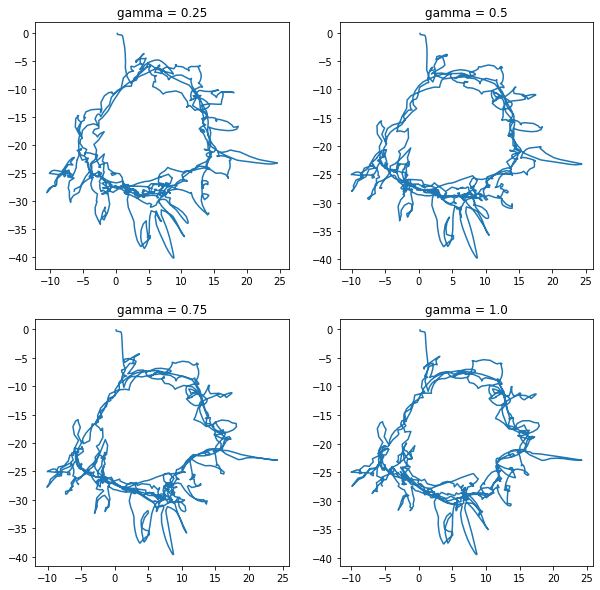

In [40]:
fig = plt.figure(figsize=(10,10))
for i in range(1, 5):
    ax = fig.add_subplot(2,2,i)
    ax.plot(res6[i,:N], res6[i,N:2*N])
    ax.set_title(f"gamma = {i/4}")
plt.show()

On observe que moins le poids des boucles apparaît, moins le robot semble faire de va et viens sur ses positions. Pour $\gamma$ petit, on observe que la trajectoire est plus "claire" tout en ayant une allure plus réaliste que sans ajout des informations de boucles. Essayons alors avec un $\gamma$ plus petit pour voir quel résultat on obtient.

In [42]:
res7 = np.zeros(res4_pf.shape[0])
t7 = 0

start = time.time()
res7 = optim_gradient_fixed_step(grad_h, res4_pf, 0.015, bouclage = True, lbd = 0.1, max_iter=1000) #pf = pas fixe
end = time.time()
t7 = end-start

Nombre d'itérations :  1000
||grad(h)||: 20.517714760730485


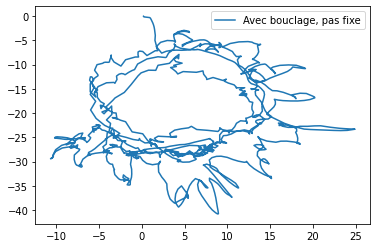

In [43]:
plt.plot(res7[:N], res7[N:2*N], label = "Avec bouclage, pas fixe")
plt.legend()
plt.show()

La trajectoire se rapproche alors d'avantage de celle sans bouclage. La trajectoire est net mais, les positions éloignées de $p_0$ sont probablement éloignées de la réalité à cause des erreurs accumulé par le calcul. Ajouter le bouclage permet, avec un $\gamma$ suffisamment élevé, de corriger ces erreurs. Si en revanche ce paramètre est trop élevé, le robot semble faire des allez retour sur ses positions. 